<a href="https://colab.research.google.com/github/upadhyayprakash/eva4/blob/master/S5/EVA4_Session_5_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Session-5 Assignment**
Train MNIST to **99.4%** or more validation accuracy with following constraints:
1. Less than 10k parameters
2. Less than 15 Epochs
3. **Must** show 99.4% consistently in last few epochs(Not just one appearance)

#### **RESULT**
1. Val Accuracy: **__%** at 17th Epoch
2. No. of parameters: ___
3. No. of Epoch: ___ Epochs (for __% Accuracy)
4. Concepts Used: 1x1 Conv, Batch Normalization, Dropout, Avg Pooling, ReLU, Batch_Size, Optimizer, transforms module for Image Augmentation.

**TO BE TRIED:** CutOut: work in Progress.

In [0]:
# Load libraries

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Checking the MEAN and Standard Deviation of MNIST Data

simple_transforms = transforms.Compose([
  transforms.ToTensor()
])

mnist_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=True, download=True, transform=simple_transforms)
mnist_data = mnist_data_source.data
mnist_data_numpy = mnist_data_source.transform(mnist_data.numpy())

print('Stats for [Train] MNIST Data - MEAN and STD Calculation')
print(' - Numpy Shape:', mnist_data_source.data.cpu().numpy().shape)
print(' - Tensor Shape:', mnist_data_source.data.size())
print(' - min:', torch.min(mnist_data_numpy))
print(' - max:', torch.max(mnist_data_numpy))
print(' - mean:', torch.mean(mnist_data_numpy))
print(' - std:', torch.std(mnist_data_numpy))
print(' - var:', torch.var(mnist_data_numpy))

Stats for [Train] MNIST Data - MEAN and STD Calculation
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [0]:
# Define Data Transformation at Training and Testing phase

train_transformations = transforms.Compose([
  # transforms.Resize((28, 28)),
  # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,)) # Calculated MEAN and Standard Deviation from MNIST data
])

test_transformations = transforms.Compose([
  # transforms.Resize((28, 28)),
  # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
])

In [0]:
# Define Data Source

train_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=True, download=True, transform=train_transformations)
test_data_source = datasets.MNIST('/home/prakash/Prakash/EVA4/Session-5/Notebooks/dataMNIST', train=False, download=True, transform=test_transformations)

In [5]:
# Define Data Loaders

SEED = 1

# GPU(CUDA) Available?
cuda = torch.cuda.is_available() # returns True/False
print("GPU Available?", cuda)

torch.manual_seed(SEED)

if(cuda):
  torch.cuda.manual_seed(SEED)

# Defining Data Loader arguments as a dictionary, based on if GPU OR CPU usage
dataLoaderArguments = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train Data Loader
train_data_loader = torch.utils.data.DataLoader(train_data_source, **dataLoaderArguments)

# Test Data Loader
test_data_loader = torch.utils.data.DataLoader(test_data_source, ** dataLoaderArguments)

GPU Available? True


In [6]:
# Data Shape/Size

dataIter = iter(train_data_loader)
images, labels = dataIter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


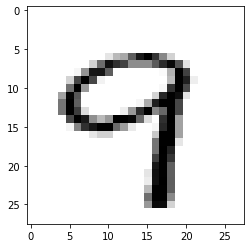

In [7]:
# Visualizing Single Image

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

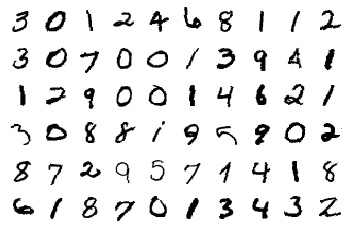

In [8]:
# Visualizing Multiple Images in Grid

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
# Defining the MNIST Network Architecture
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [11]:
# Model Summary: Used to know # of Parameters, Model Size Prediction, Network Architecure review.

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device Used: ", device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

Device Used:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14

In [0]:
# Training and Testing routines

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# Model Training and Validation/Testing
from torch.optim.lr_scheduler import StepLR, LambdaLR # LR Scheduler

model =  MNISTNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15

scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# start_lr = 0.1
# end_lr = 1e-7
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (EPOCHS * len( train_data_loader)))
# scheduler = LambdaLR(optimizer, lr_lambda))


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_data_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_data_loader)
    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1570877581834793 Batch_id=468 Accuracy=86.17: 100%|██████████| 469/469 [00:06<00:00, 69.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.06513344496488571 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:06<00:00, 74.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.08551951497793198 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:07<00:00, 63.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.05415577068924904 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:07<00:00, 63.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.02503025531768799 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:07<00:00, 61.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.12307216972112656 Batch_id=342 Accuracy=98.55:  72%|███████▏  | 337/469 [00:05<00:02, 64.47it/s] 

In [0]:
# Visualizing Training and Testing Results

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")